# Исследование надёжности заёмщиков
## Описание проекта

Цель - определить, влияет ли семейное положение, количество детей клиента и другие факторы на погашение кредита в срок.

Входные данные — статистика о платёжеспособности клиентов банка.


## Оглавление
* [Шаг 1. Открытие файла с данными и изучение общей информации](#h1_1)
* [Шаг 2. Предобработка данных](#h1_2)
    * [Обработк пропусков](#h2_2_1)
    * [Обработка дубликатов](#h2_2_2)
    * [Лемматизация](#h2_2_3)
    * [Категоризация данных](#h2_2_4)
* [Шаг 3. Исследовательский анализ данных](#h1_3)
* [Шаг 4. Общий вывод](#h1_4)

### Библиотеки для работы с данными

In [ ]:
import pandas as pd
from nltk.stem import SnowballStemmer
import numpy as np
from pymystem3 import Mystem

## Шаг 1. Открытие файла с данными и изучение общей информации<a class="anchor" id="h1_1"></a>

In [68]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В столбце `days_employed` и `total_income` имеются пропущенные значения.
Столбец `days_employed` имеет формат `float64`, т.е. там указано не целое количество дней.

Посмотрим на примеры значений:

In [69]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


При первом взгляде на данные бросается в глаза, что:
* `days_employed` - в данном параметре присутствуют отрицательные, а также сверхвысокие значения.
* `education` - присутствуют одни и те же значения (по смыслу), но в разных регистрах
* `purpose` - здесь имеется более сложные дубликаты, чем в `education`. По-видимому, для работы с ним потребуется лемматизация.

Изучим подробнее значения в других столбцах.

##### Столбец children

Посмотрим список уникальных значений столбца `children`. Для наглядности отсортируем значения по возрастанию (для этого подключаем библиотеку `numpy`, т.к. необходимо отсортировать объект `numpy.ndarray`)

In [70]:
print(np.sort(df['children'].unique()))

[-1  0  1  2  3  4  5 20]


Значения -1 и 20 сильно выбиваются из выборки. Посмотрим на них подробнее в разделе обработки пропусков.

##### Столбец days_employed
При первом взгляде на данные мы обнаружили странные значения в данном столбце: одни значения были отрицательными, а другие - сверхвысокими.
Попробуем сначала разобраться со вторыми. Подсчитаем количество записей больше 0.

In [71]:
print(df[(df['days_employed'] > 0)]['days_employed'].count())

3445


3445 значений больше нуля. В рассмотренных примерах данных все положительные значения почему-то очень большие. Проверим, действительно ли это так.

In [72]:
print(df[(df['days_employed'] > 300000)]['days_employed'].count())

3445


Построим гистограмму распределения параметра `days_employed`.

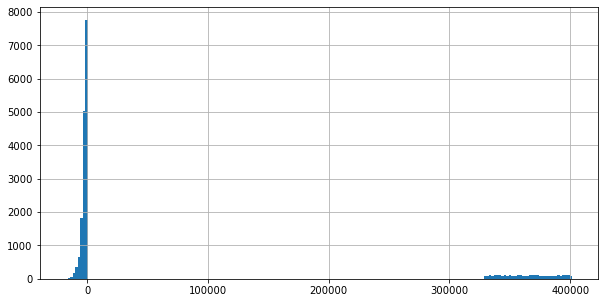

In [73]:
df['days_employed'].hist(figsize=(10,5),bins=200)

Все положительные значения оказались больше 300000. 300 тысяч дней - это более 800 лет. С этими значениями явно что-то не так.
Посмотрим подробнее на данные с такими записями.

In [74]:
df[(df['days_employed'] > 300000)].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
18,0,400281.136913,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823.777243,на покупку подержанного автомобиля
24,1,338551.952911,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547.235997,операции с коммерческой недвижимостью
25,0,363548.489348,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112.757732,покупка недвижимости
30,1,335581.668515,62,среднее,1,женат / замужем,0,F,пенсионер,0,171456.067993,операции с коммерческой недвижимостью


Возможно, что все эти люди не работают (у всех этих записей income_type = 'пенсионер'). Проверим данную гипотезу.

In [75]:
print(df[(df['days_employed'] > 0)]['income_type'].unique())

['пенсионер' 'безработный']


Все люди со сверхвысокими значением столбца `days_employed` или безработные, или пенсионеры. Но это еще не значит, что у всех безработных и пенсионеров `days_employed` имеет некорректное значение в данных.

Например, посмотрим с этой позиции на пенсионеров:

In [76]:
print('Пенсинеров с положительным значением days_employed:',df[(df['income_type'] == 'пенсионер') & (df['days_employed'] > 0)]['days_employed'].count())
print('Всего пенсионеров:',df[(df['income_type'] == 'пенсионер')]['income_type'].count())

Пенсинеров с положительным значением days_employed: 3443
Всего пенсионеров: 3856


Полученный результат можно объяснить тем, что часть пенсионеров может продолжать где-то работать. А большинство пенсионеров действительно не работают. Возможно как раз для неработающих и выгружается некорректно данный параметр.

##### Столбец dob_years
Посмотрим список уникальных значений столбца `dob_years`. Для наглядности отсортируем значения по возрастанию

In [77]:
print(np.sort(df['dob_years'].unique()))

[ 0 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75]


Среди всех аномальным 0, что для нас по сути является пропуском.

In [78]:
#Посмотрим список уникальных значений столбца education.
print(df['education'].unique())

['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']


Необходимо привести значения к единому виду.

In [79]:
print(df['education_id'].unique())

[0 1 2 3 4]


Значения столбцов `education` и `education_id` должны соответствовать друг другу. Поэтому если в дальнейшем потребуется использовать `education_id`, необходимо также проверить, нет ли в данном случае противоречий.

##### Столбец family_status

In [80]:
df['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

В family_status проблем не видно.

##### Столбец gender

In [81]:
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Как видно, имеется одна запись с пропущеннм значением в виде строки `'XNA'`.

##### Столбец income_type

In [82]:
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

В income_type проблем не видно.

##### Столбец debt

In [83]:
df['debt'].value_counts()

0    19784
1     1741
Name: debt, dtype: int64

В debt проблем не видно.

#### Вывод

На основе общей информации видно, что:
* `days_employed` - присутствуют пропущенные, отрицательные, а также сверхвысокие значения. Что можно сделать сейчас: посмотреть, как часто встречаются такие значения. Другое дело, а нужны ли нам вообще эти данные применительно к нашей задаче? В текущей постановке нет необходимости проводить анализ влияния стажа на возврат кредита в срок. Для учебных целей мы обработаем значение в данном столбце Шаге 2. В любом случае похоже есть проблема с выгрузкой и надо сообщить об этом коллегам, отвечающим за неё.
* `children` - значения -1 и 20 сильно выбиваются из выборки. -1 является явным пропуском.
* `education` - присутствуют одни и те же значения, но в разных регистрах
* `total_income` - есть пропущенные значения
* `purpose` - здесь имеется более сложные дубликаты, чем в `education`. Для них потребуется провести лемматизацию
* `gender` - в данном столбце имеются пропущенные значения в виде строк `'XNA'`
* `dob_years` - имеются пропуски в виде значений 0.
* `purpose` - похоже, что в данный столбец вписывается причина обращения за кредитом в свободной форме. Поэтому для работы с значениями в этом столбце потребуется их лемматизировать.

### Шаг 2. Предобработка данных<a class="anchor" id="h1_2"></a>

### Обработка пропусков<a class="anchor" id="h2_2_1"></a>
Пропуски были найдены в столбцах `days_employed`, `total_income`, `gender`, `children`.
Посмотрим на них подробнее и обработаем.
#### Столбец `days_employed`
Ранее мы выяснили, что в данном столбце есть множество проблем:
1. Имеются пропущенные значения
2. Сверхвысокие значения у людей, не имеющих работы
2. Отрицательные значения для всех остальных

Сначала обработаем сверхвысокие значения. Заменим их на 0:

In [84]:
df.loc[df.days_employed > 300000, 'days_employed'] = 0

Также заменим на 0 пропущенные значения:

In [85]:
df['days_employed'] = df['days_employed'].fillna(value=0)

Отрицательные значения выглядят более реальными, если взять их по модулю. Поэтому заменим их на положительные:

In [86]:
df['days_employed'] = df['days_employed'].apply(abs)

Поскольку данный столбец имеет количественное значение, то заменим пропущенные значения на среднее. Только рассчитать его нужно без учета некорректных значений (сейчас такие значения мы сделали нулями).

In [87]:
days_employed_avg = df.loc[df.days_employed > 0, 'days_employed'].mean()

In [88]:
print('Средний стаж:',days_employed_avg)

Средний стаж: 2353.015931998879


Теперь заменим все некорректные (нулевые на текущий момент) значения на среднее значение:

In [89]:
df.loc[df.days_employed ==0 , 'days_employed'] = days_employed_avg

Для наглядности посмотрим гистограмму:

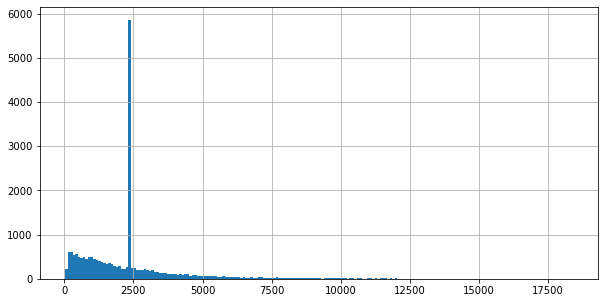

In [90]:
df['days_employed'].hist(figsize=(10,5),bins=200)

Некорректные значения обработаны и заменены на среднее. Но, очевидно, что таких некорректных значений очень много. Если бы нам нужно было делать анализ с использованием данного столбца, то замена на среднее внесла бы сильные изменения в результаты анализа. В зависимости от цели возможно было бы более правильно разделить данные на определенные группы (например, возраст человека, т.к. он сильно связан со стажем), и подсчитать среднее или медиану для каждой группы, а далее заполнить `days_employed` этими значениями.

#### Столбец `total_income`
Поскольку это количественное значение, то заменим пропуски на среднее значение или медиану. Возьмем медиану:

In [91]:
total_income_median = df['total_income'].median()
print('Медиана дохода:',total_income_median)

Медиана дохода: 145017.93753253992


In [92]:
df['total_income'] = df['total_income'].fillna(value=total_income_median)

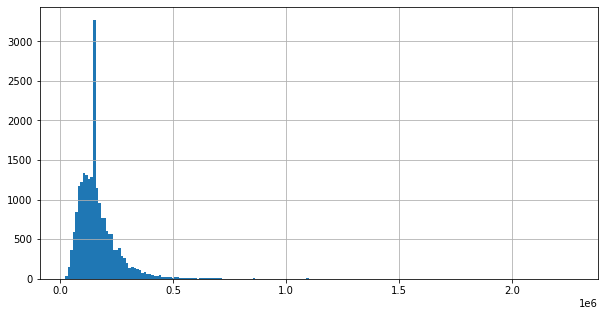

In [93]:
df['total_income'].hist(figsize=(10,5),bins=200)

Пропущенные значения заменены на медианные. И здесь также, как и при обработке days_employed, мы видим сильный всплеск, который может повлиять на те выводы, которые будем делать впри анализе данных с использованием данного параметра в дальнейшем.

#### Столбец `gender`

Для начала посмотрим, как часто встречаются пропущенные значения в данной колонке.

In [94]:
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Оказалось, что иммется всего одна запись с таким значеним. Посмотрим, есть ли в ней аномилии:

In [95]:
df.loc[df.gender == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


Аномалий не найдено. Некорректно было бы выделять эту запись в отдельную категорию, поэтому можно либо удалить данную запись, либо заменить пропущенное значение на самое распространненное. Заменим значение на `'F'`:

In [96]:
df.loc[df.gender == 'XNA', 'gender'] = 'F'

#### Столбец `children`
При начальном просмотре данных было обнаружены несколько аномальных значений в столбце `children`: -1 и 20.
Если 20 детей еще можно объяснить (например, у человека много приемных детей), то -1 ребенка не может быть. Посмотрим подробнее на эти значение и попытаемся понять, есть ли какая-то связь таких значений с другими данными.

In [97]:
df[(df['children'] == -1)].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
705,-1,902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля
742,-1,3174.456205,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование
800,-1,2353.015932,54,среднее,1,Не женат / не замужем,4,F,пенсионер,0,86293.724153,дополнительное образование
941,-1,2353.015932,57,Среднее,1,женат / замужем,0,F,пенсионер,0,145017.937533,на покупку своего автомобиля


In [98]:
df[(df['children'] == 20)].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
606,20,880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья
720,20,855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости
1074,20,3310.411598,56,среднее,1,женат / замужем,0,F,сотрудник,1,229518.537004,получение образования
2510,20,2714.161249,59,высшее,0,вдовец / вдова,2,F,сотрудник,0,264474.835577,операции с коммерческой недвижимостью
2941,20,2161.591519,0,среднее,1,женат / замужем,0,F,сотрудник,0,199739.941398,на покупку автомобиля


При этих значениях не видится какой-то конкретной связи с другими столбцами. Похоже, что это проблема выгрузки данных, о ней нужно сообщить ответственным.

In [99]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Поскольку `children` - количественное значение, то заменим значение -1 на среднее значение (т.е. 0).

In [100]:
df.loc[df.children == -1, 'children'] = 0

 Значение 20 оставим без изменения, хотя 76 записей выглядит аномально много с учетом того, что записей нет вовсе на отрезке от 6 до 19.

#### Столбец `dob_years`

Посмотрим подробнее на значения, в которых количество лет указано как 0.

In [101]:
df[(df['dob_years'] == 0)].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
99,0,2353.015932,0,Среднее,1,женат / замужем,0,F,пенсионер,0,71291.522491,автомобиль
149,0,2664.273168,0,среднее,1,в разводе,3,F,сотрудник,0,70176.435951,операции с жильем
270,3,1872.663186,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью
578,0,2353.015932,0,среднее,1,женат / замужем,0,F,пенсионер,0,97620.687042,строительство собственной недвижимости
1040,0,1158.029561,0,высшее,0,в разводе,3,F,компаньон,0,303994.134987,свой автомобиль


В этих данных не видно чего-то необычного. Заполним данные пропуски медианой возраста клиента:

In [102]:
df.loc[df.dob_years == 0, 'dob_years'] = int(df['dob_years'].median())

Проверим результат, построив гистограмму для этого столбца:

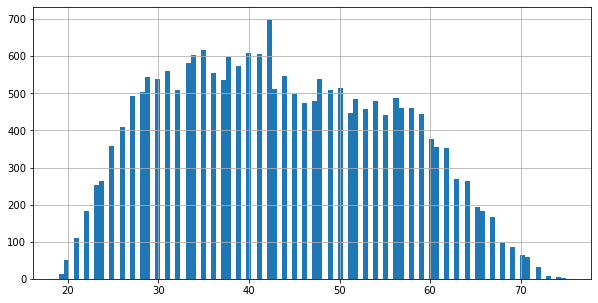

In [103]:
df['dob_years'].hist(figsize=(10,5),bins=100)

Теперь нулевых значений нет.

#### Вывод

Выявленные пропуски обработаны. 
* `days_employed` - количественный параметр, поэтому пропуски решено заменить на среднее значение. Но некорректных значений очень много. Если бы нам нужно было делать анализ с использованием данного столбца, то замена на среднее внесла бы сильные изменения в результаты анализа.
* `total_income` - количественный параметры, прописки решено заменить на медиану
* `children` - отрицательное значение заменено на среднее (0). 76 клиентов с 20 детьми выглядит аномально много с учетом того, что записей нет вовсе на отрезке от 6 до 19. Стоит обратить на это внимание ответственным по выгрузке.
* `dob_years` - нулевые значения в столбце заменены на медиану.

### Замена типа данных

Можно заменит тип данных у столбца days_employed на integer, т.к. в описании указано, что в данном параметре должно быть количество трудовых дней стажа. По смыслу это целое число. Но видимо при выгрузке это значение калькулируется на основе какого-то значения timestamp с точность до секунд. В результате вычисление получается дробное значение.
В нужный тип значения переводят методом astype():

In [104]:
df['days_employed'] = df['days_employed'].astype('int')

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

В том числе метод `astype` и `fillna` можно применять к нескольким столбцам одновременно.
    
Если столбцов более 2–ух, то рекомендую применять цикл `for`.
    
</div>

Проверим результат преобразования:

In [105]:
df['days_employed'].head()

0    8437
1    4024
2    5623
3    4124
4    2353
Name: days_employed, dtype: int64

#### Вывод

Тип данных столбца days_employed заменен с вещественного на целочисленный.

### Обработка дубликатов<a class="anchor" id="h2_2_2"></a>

Проверим данные на грубые дубликаты (повторы):

In [106]:
print('Количество повторов в данных:',df.duplicated().sum())

Количество повторов в данных: 55


Посмотрим подробнее на эти дубликаты:

In [107]:
df[df.duplicated()].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,2353,41,среднее,1,женат / замужем,0,F,сотрудник,0,145017.937533,покупка жилья для семьи
4182,1,2353,34,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,145017.937533,свадьба
4851,0,2353,60,среднее,1,гражданский брак,1,F,пенсионер,0,145017.937533,свадьба
5557,0,2353,58,среднее,1,гражданский брак,1,F,пенсионер,0,145017.937533,сыграть свадьбу
7808,0,2353,57,среднее,1,гражданский брак,1,F,пенсионер,0,145017.937533,на проведение свадьбы


Мы видим, что столбцы `days_employed` и `total_income` у этих записей одинаковы. Эти значения совпадают с тем, которыми мы заполняли данные на предыдущем этапе. Ранее же у этих записей там стояли значения `NaN`. Т.е. по сути эти данные могут вовсе не являться дубликатами. Скорее всего это разные кредиты. Проблема в том, что у нас нет явного идентификатора записи (например, ID кредита). К тому же данные в других столбцах достаточно простые. Поэтому скорее всего это все-таки данные о разных кредитах. Для нашей задачи эти данные можно оставить.

C другой стороны, повторов не так много (всего 55). Удалим их позже, т.к. после обработки других полей могут выявиться новые дубликаты.

При первичном осмотре мы нашли похожие значения в столбце `education`, но написанные в разном регистре.
Переведем значения в нижний регистр:

In [108]:
df['education'] = df['education'].str.lower()

Проверим результат:

In [109]:
print(df['education'].value_counts())

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64


После приведения столбца `education` к единому виду посмотрим, нет ли проблем при сочетании столбцов `education` и `education_id`. Выведем список возможных комбинаций значений из данных колонок:

In [110]:
df.groupby(['education','education_id']).size().reset_index().rename(columns={0:'count'})

,education,education_id,count
0,высшее,0,5260
1,начальное,3,282
2,неоконченное высшее,2,744
3,среднее,1,15233
4,ученая степень,4,6


Как видно, тут все в порядке: каждому значению `education_id` соответствует только одно значение `education`.

Теперь значения в `education` выглядят намного лучше. Но проверим еще раз набор данных на пропуски:

In [111]:
print('Количество дублей в данных:',df.duplicated().sum())

Количество дублей в данных: 72


Появились новые повторы после того, как мы привели значения в поле `education` к нижнему регистру. Удалим данные повторы:

In [112]:
df = df.drop_duplicates().reset_index(drop = True)

#### Вывод

1. Найдены полные дубли в данных (полные повторы строк). Но решено было их не удалять, поскольку эти записи скорее всего содержат информацию о разных кредитах.
2. Повторы значений `education` приведены к единому виду (изменен регистр).
3. После приведения к единому виду в поле `education` в данных обнаружились новые повторы. Поэтому важно сначала привести значения в колонках к общему виду, а затем искать и удалять повторы.

### Лемматизация<a class="anchor" id="h2_2_3"></a>

Для того, чтобы ответить на вопрос, как разные цели кредита влияют на его возврат в срок, лемматизируем значения в графе, где было указана цель кредита (`purpose`).
Для начала создадим список уникальных значений поля `purpose`:

In [113]:
purpose_unique = df['purpose'].unique()
print('Уникальных значений столбца purpose:',len(purpose_unique))

Уникальных значений столбца purpose: 38


Оказалось их не так много, что очень хорошо, т.к. лемматизация - достаточно затратный процесс по производительности.
Далее выполним лемматизацию:

In [114]:
m = Mystem()
#создадим словарь, куда будем вписысывать уникальные слова по и как часто они встречаются (не во всех данных, а только среди уникальных значений колонки purpose)
dict={}
#Цикл по индексам purpose_unique
for i in range(len(purpose_unique)-1):
    lemmas = m.lemmatize(df.loc[i, 'purpose'])
    #Цикл по всем значениям, полученным в результате лемматизации одной строки из purpose_unique
    for word in lemmas:
        #Если слова нет в словаре, то добавляем его туда. Если слова есть, то прибавляем в счетчику +1
        if word not in dict:
            dict[word] = 1
        else:
            dict[word] +=1
#Выведем полученный словарь на экран
print(dict)

{'покупка': 12, ' ': 55, 'жилье': 7, '\n': 37, 'приобретение': 3, 'автомобиль': 7, 'дополнительный': 1, 'образование': 3, 'сыграть': 3, 'свадьба': 6, 'операция': 4, 'с': 3, 'на': 6, 'проведение': 3, 'для': 1, 'семья': 1, 'недвижимость': 14, 'коммерческий': 3, 'жилой': 2, 'строительство': 5, 'собственный': 3, 'подержать': 2, 'свой': 2, 'со': 1}


Лемматизированный словарь:

Среди данных слов можно выделить следующие категории:
* недвижимость (слова жилье, недвижимость)
* автомобиль
* свадьба
* образование

При этом хотелось бы отделить коммерческую недвижимость от жилой. Но имеются значения `purpose`, в которых не указывается, какая это недвижимость. Поэтому оставим данную группу единой.
Создадим функцию `purpose_group()` для группировки по предложенным категориям.
Но для начала нужно найти основу слов, которые мы будем использовать в нашей функции. Для этого воспользуемся стеммингом:

In [115]:
russian_stemmer = SnowballStemmer('russian')
print(russian_stemmer.stem('автомобиль'))
print(russian_stemmer.stem('недвижимость'))
print(russian_stemmer.stem('свадьба'))
print(russian_stemmer.stem('образование'))
print(russian_stemmer.stem('жилье'))

автомобил
недвижим
свадьб
образован
жил


Теперь можно создать функцию:

In [116]:
def purpose_group(text):
    if ('жил' in text) or ('недвижим' in text):
        return 'недвижимость'
    if 'автомобил' in text:
        return 'автомобиль'
    if 'свадьб' in text:
        return 'свадьба'
    if 'образован' in text:
        return 'образование'
    else:
        return 'без категории'

Добавим столбец purpose_group, где будут храниться результаты применения функции purpose_group()

In [117]:
df['purpose_group'] = df['purpose'].apply(purpose_group)

На всякий случай проверим, нет ли значений, оставшихся без категории:

In [118]:
print(df['purpose_group'].unique())

['недвижимость' 'автомобиль' 'образование' 'свадьба']


#### Вывод

По результатам лемматизации удалось выделить 4 категории целей, на которые заемщики берут кредит.

### Категоризация данных<a class="anchor" id="h2_2_4"></a>

Для того, чтобы ответить на вопрос о зависимости между уровнем дохода и возвратом кредита в срок, нам необходимо категоризировать параметр дохода клиента (`total_income`). Посмотрим описание данного параметра:

In [119]:
df['total_income'].describe()

count    2.145300e+04
mean     1.652271e+05
std      9.802320e+04
min      2.066726e+04
25%      1.076209e+05
50%      1.450179e+05
75%      1.958188e+05
max      2.265604e+06
Name: total_income, dtype: float64

Большая часть значений попадает в группу с уровнем дохода до 200 тыс, что намного меньше максимального значения.
Разобьем значения данного параметра на относительно равные категории. Выделим значения ближе к среднему (165 тыс.) в отдельную категорию - от 100 до 200 тыс. 

Создадим функцию `income_group()`, с помощью которой мы выделим несколько групп.

In [120]:
def income_group(income):
    if income < 100000:
        return 'ниже среднего'
    elif income < 200000:
        return 'средний'
    elif income < 300000:
        return 'выше среднего'    
    else:
        return 'высокий'

Создадим столбец income_group и заполним его, применив новую функцию к столбцу `total_income`:

In [121]:
df['income_group'] = df['total_income'].apply(income_group)

#### Вывод

В результате выполнения категоризации данные были разбиты на группы по уровню дохода (столбец `income_group`).
Оказалось, что не всегда удобно делить данные на равные группы. В нашем случае в крайнюю группу вошли все значения от 300 тыс до 2.2 млн.

## Шаг 3. Исследовательский анализ данных<a class="anchor" id="h1_3"></a>
#### Есть ли зависимость между наличием детей и возвратом кредита в срок?
Создадим таблицу `child_grouped`, в которую запишем результат группировки данных по столбцу `children`. Подсчитаем для каждой группы общее количество записей (колонка `count`) и сумму (колонка sum) по столбцу `debt`.
Далее добавим столбец `child_share`, в котором поделим столбец sum на count. В результате получим долю клиентов с задолженностями для каждой группы.

In [122]:
child_grouped = df.groupby('children').agg({'debt': ['count', 'sum']})
child_grouped['child_share'] = child_grouped['debt']['sum'] / child_grouped['debt']['count']
child_grouped.sort_values(by = 'children', ascending = False)

debt       child_share
          count   sum            
children                         
20           76     8    0.105263
5             9     0    0.000000
4            41     4    0.097561
3           330    27    0.081818
2          2052   194    0.094542
1          4808   444    0.092346
0         14137  1064    0.075263

При появлении детей у клиентов резко возрастают невыплаты по кредитам.
Посмотрим, на сколько процентов возрастает количество просрочек у людей с детьми по сравнению с людьми без детей.
Клиентов из аномальной группы с 20 детьми немного, поэтому включение их в расчеты не должно сильно повлиять на разультат.

Разделим данные на две группы: без детей из с детьми и подсчитаем долю невыплат.

In [123]:
df['child_group'] = pd.cut(df['children'],[-1,0,df['children'].max()])
df.groupby('child_group')['debt'].agg(['count','mean'])

,count,mean
child_group,,
"(-1, 0]",14137,0.075263
"(0, 20]",7316,0.092537


In [124]:
print('Количество просрочек у людей с детьми по сравнению с людьми без детей возрастает на {:.0%}.'.format((0.092537 - 0.074951) / 0.074951))

Количество просрочек у людей с детьми по сравнению с людьми без детей возрастает на 23%.


##### Вывод

Результаты показывают, что у людей с детьми (даже с одним) значительно возрастает количетво просрочек по сравнению с клиентами без детей.

#### Есть ли зависимость между семейным положением и возвратом кредита в срок?

Для ответа на этот вопрос сгруппируем данные по семейному положению и рассчитаем долю выплативших кредит для каждой группы. Для этого необходимо подсчитать для каждой группы количество клиентов, выплативших кредит, и разделить его на общее количество клиентов в группе

In [125]:
family_grouped = df.groupby('family_status').agg({'debt': ['count', 'sum']})
family_grouped['debt_share'] = family_grouped['debt']['sum'] / family_grouped['debt']['count']
display(family_grouped.sort_values(by = 'debt_share', ascending = False))

debt      debt_share
                       count  sum           
family_status                               
Не женат / не замужем   2810  274   0.097509
гражданский брак        4150  388   0.093494
женат / замужем        12339  931   0.075452
в разводе               1195   85   0.071130
вдовец / вдова           959   63   0.065693

Представим полученны результат в виде столбчатой диаграммы:

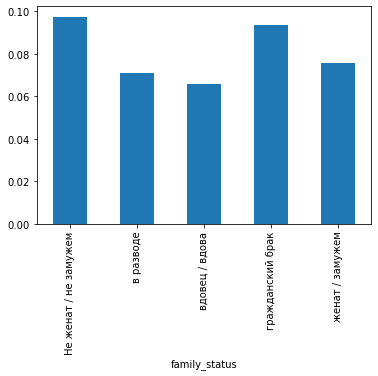

In [126]:
df.groupby('family_status')['debt'].mean().plot(kind='bar')

##### Вывод

Люди, которые не были в браке или неоформившие свои отношения, в среднем более склонны к невыплате кредита, чем те, кто уже создал семьи. Меньше всего просрочек у тех, кто остался один, т.е. кто развелся или овдовел.
Таким образом, семейное положение может свидетельствовать о том, насколько серезно заемщик будет относится к уплате кредита.
Но здесь есть сильная связь с возрастом заемщика. Возможно стоит дополнительно проверить данную связь, сгруппировав людей по разному возрасту.

#### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Подсчитаем долю должников среди выделенных ранее категорий уровня дохода:

In [127]:
df.groupby('income_group')['debt'].agg(['mean'])

,mean
income_group,
высокий,0.071525
выше среднего,0.070312
ниже среднего,0.079319
средний,0.086297


##### Вывод

Больше всего должников оказывается в группе людей со средним доходом. С увеличеним дохода доля невыплат уменьшается.

#### Как разные цели кредита влияют на его возврат в срок?

In [128]:
purpose_grouped = df.groupby('purpose_group').agg({'debt': ['count', 'sum']})
purpose_grouped['debt_share'] = purpose_grouped['debt']['sum'] / purpose_grouped['debt']['count']
display(purpose_grouped.sort_values(by = 'debt_share', ascending = False))

debt      debt_share
               count  sum           
purpose_group                       
автомобиль      4306  403   0.093590
образование     4013  370   0.092200
свадьба         2323  186   0.080069
недвижимость   10811  782   0.072334

Представим полученный результат в виде столбчатой диаграммы:

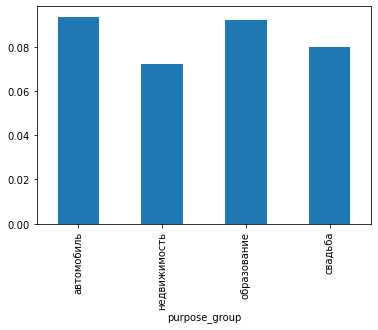

In [129]:
df.groupby('purpose_group')['debt'].mean().plot(kind='bar')

##### Вывод

Самые низкие просрочки у заемщиков, взявших кредит на недвижимость. Это можно объяснить тем, что люди перед такой покупкой склонны больше взвешивать все "за" и "против". С этой точки зрения покупка автомобиля из данных четырех категорий - самая "легкомысленная" покупа. По ним и доля просрочек самамя высокая. Но и образование оказалось в числе лидеров. Для объяснения данного феномена нужно подробнее изучить данные. Возможно это как-то связано с возрастом заемщиков и уровнем их дохода.

### Шаг 4. Общий вывод

Проведенный анализ позволил ответить на изначально поставленные кредитным отделом банка вопросы о влиянии различных факторов на способность клиент погасить кредит в срок: 
* семейное положение - люди, которые не были в браке или неоформившие свои отношения, в среднем более склонны к невыплате кредита, чем те, кто уже создал семьи. Меньше всего просрочек у тех, кто остался один, т.е. кто развелся или овдовел. Таким образом, семейное положение может свидетельствовать о том, насколько серезно заемщик будет относится к уплате кредита.
* количество детей клиента - с появлением детей платежеспособность клиента снижается. Доля просрочек увеличивается на 23% по сравнению с клиентами без детей
* уровень дохода - наибольшее количество просрочек наблюдается у клиентов со средним доходом. С ростом дохода количество просрочеку уменьшается
* цель кредита - наименьшее количество просрочек появляется при покупке недвижимости. Значительно большее количество просрочек возникает при получении кредитов на автомобиль и на образование.